# Example 1

In this notebook we show how to pick a single test point within bayessian optimization approach. We use the simpliest combination of [Gaussian Process](https://distill.pub/2019/visual-exploration-gaussian-processes/) and [Expected Improvement](https://botorch.org/api/_modules/botorch/acquisition/analytic.html#ExpectedImprovement) acquisition function.

In [1]:
# Necessary imports
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
from pylab import meshgrid
import matplotlib.pyplot as plt

/opt/anaconda3/envs/hackaton/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we define function used to describe "real" model. This function plays role of pseudoexperiment - in real life it is unknown, we do experiments to measure it in proposed points, and our algorithm aims to find its global minimum.

In [2]:
def func(x):
    return standardize(1-torch.norm(x-0.5, dim=-1, keepdim=True))

That's how our function looks like:

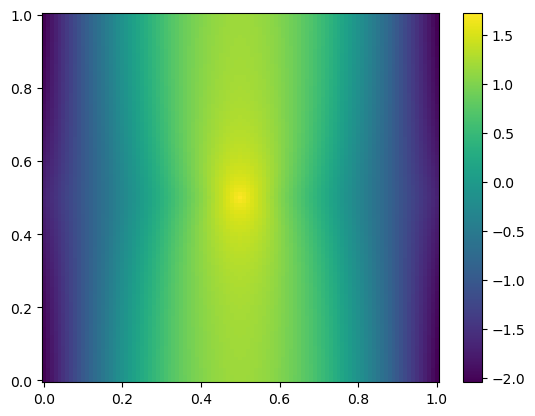

In [3]:
x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
X,Y = meshgrid(x, y) # grid of point
Z = func(torch.cat((torch.unsqueeze(torch.tensor(X), dim=-1), torch.unsqueeze(torch.tensor(Y), dim=-1)), dim = -1))
Z = torch.squeeze(Z, dim = -1)
fig, ax = plt.subplots()
m = ax.pcolormesh(X, Y, Z)
plt.colorbar(m) # adding the colobar on the right


Here we define starting dataset.

In [4]:
train_X = torch.rand(10, 2)
train_Y = func(train_X)

That's where are the test samples are located:

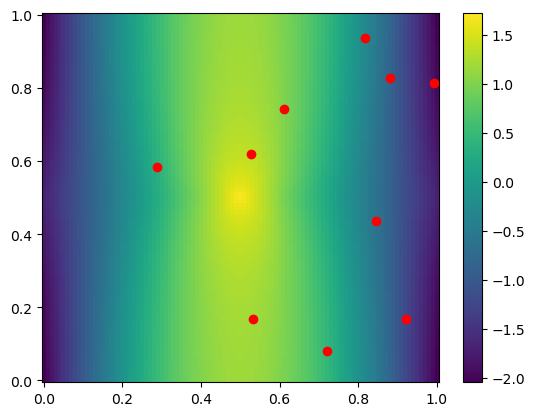

In [5]:
x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
X,Y = meshgrid(x, y) # grid of point
Z = func(torch.cat((torch.unsqueeze(torch.tensor(X), dim=-1), torch.unsqueeze(torch.tensor(Y), dim=-1)), dim = -1))
Z = torch.squeeze(Z, dim = -1)
fig, ax = plt.subplots()
m = ax.pcolormesh(X, Y, Z)
ax.scatter(train_X.T[0], train_X.T[1], color = 'red')
plt.colorbar(m) # adding the colobar on the right


Let's train our model now.

In [6]:
# Defining the model
gp = SingleTaskGP(train_X, train_Y)
# Defining cost function
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
# Set model's parameters to those that maximize likelihood.
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

Let's see how our model looks like after training:

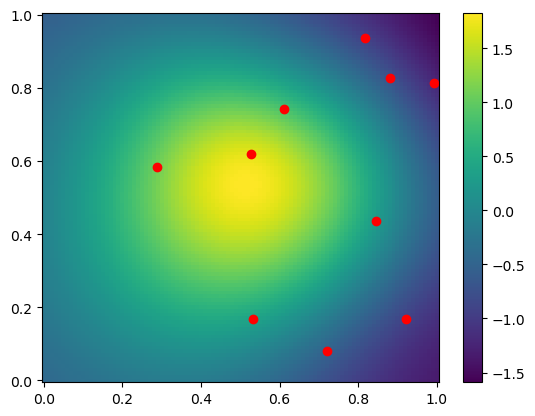

In [7]:
from torch import float
x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
X,Y = meshgrid(x, y) # grid of point
xy = torch.cat((torch.unsqueeze(torch.tensor(X, dtype = float), dim=-1), 
                             torch.unsqueeze(torch.tensor(Y, dtype = float), dim=-1)), dim = -1)
Z = mll.model.posterior(xy.squeeze(dim = 0)).mean
Z = torch.squeeze(Z, dim = -1)
fig, ax = plt.subplots()
m = ax.pcolormesh(X, Y, Z.detach().numpy())
ax.scatter(train_X.T[0], train_X.T[1], color = 'red')
plt.colorbar(m) # adding the colobar on the right


We pick acquisition funciton now. We will select our best candidate based on the acquisition function.

In Unravel we usually use Expected Improvement  acquisition funcion. 

In [8]:
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
ei = ExpectedImprovement(gp, best_f = train_Y.max())


Let's see how this funciton looks like given our probes.

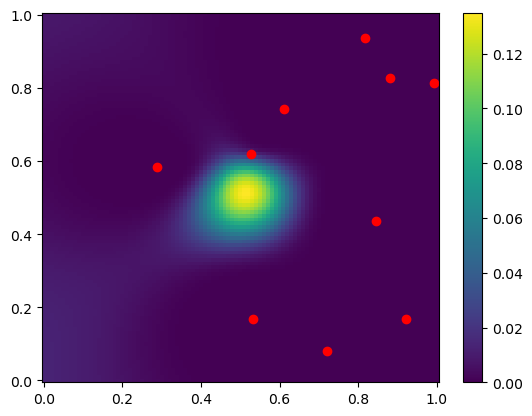

In [9]:
from torch import float
x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
X,Y = meshgrid(x, y) # grid of point
xy = torch.cat((torch.unsqueeze(torch.tensor(X, dtype = float), dim=-1), 
                             torch.unsqueeze(torch.tensor(Y, dtype = float), dim=-1)), dim = -1)
Z = ei(xy.flatten(0, 1)[:,None]).reshape(101, 101)
fig, ax = plt.subplots()
m = ax.pcolormesh(X, Y, Z.detach().numpy())
ax.scatter(train_X.T[0], train_X.T[1], color = 'red')
plt.colorbar(m) # adding the colobar on the right


Now, let's ask botorch to provide the best candidate.

In [10]:
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(2), torch.ones(2)])

candidate, acq_value = optimize_acqf(
    ei, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)

candidate  

tensor([[0.5141, 0.5123]])

And mark it on the plane.

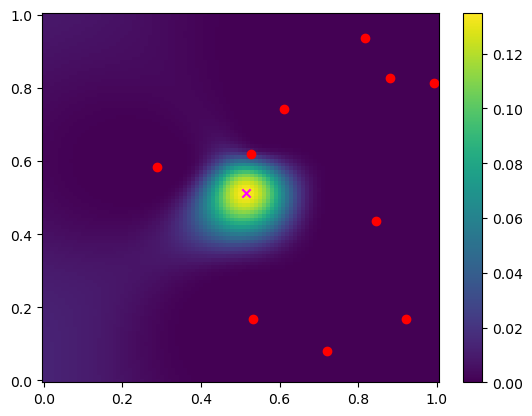

In [11]:
from torch import float
x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
X,Y = meshgrid(x, y) # grid of point
xy = torch.cat((torch.unsqueeze(torch.tensor(X, dtype = float), dim=-1), 
                             torch.unsqueeze(torch.tensor(Y, dtype = float), dim=-1)), dim = -1)
Z = ei(xy.flatten(0, 1)[:,None]).reshape(101, 101)
fig, ax = plt.subplots()
m = ax.pcolormesh(X, Y, Z.detach().numpy())
ax.scatter(train_X.T[0], train_X.T[1], color = 'red')
ax.scatter(candidate.T[0], candidate.T[1], color = 'magenta', marker = "x")

plt.colorbar(m) # adding the colobar on the right
